### Node based encoding

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.stats import confidence_interval
from frites.utils import parallel_func
from scipy.signal import fftconvolve
from tqdm import tqdm
from utils import *

from config import get_dates, return_delay_split
from GDa.flatmap.flatmap import flatmap
from GDa.graphics import plot
from GDa.session import session_info
from GDa.loader import loader
from GDa.util import shuffle_along_axis

##### Setting configurations

In [3]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [4]:
metric = "coh"
monkey = "lucy"
ds = 1

In [5]:
early_cue, early_delay = return_delay_split(monkey, delay_type=ds)

In [6]:
sessions = get_dates(monkey)

In [7]:
reg_colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

In [8]:
stages = [[-0.6, -0.2], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [9]:
bands = [[0, 6], [6, 14], [14, 26], [26, 42], [42, 80]]

In [10]:
path = os.path.expanduser("~/funcog/gda/Results/lucy/mutual_information/power")

In [50]:
p_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "pval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)
t_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "tval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)

In [12]:
p_crk = node_xr_remove_sca(
    xr.load_dataarray(os.path.join(path, "pval_crackle_1_br_1_aligned_cue_q_95_fdr.nc"))
)
t_crk = node_xr_remove_sca(
    xr.load_dataarray(os.path.join(path, "tval_crackle_1_br_1_aligned_cue_q_95_fdr.nc"))
)

In [13]:
# Get the region name for each roi
areas_dict = get_areas()
regions = np.asarray([areas_dict[roi.lower()] for roi in t_pow.roi.data])
idx = np.argsort(regions)

In [14]:
t_pow = t_pow * (p_pow <= 0.001)
t_crk = t_crk * (p_crk <= 0.001)

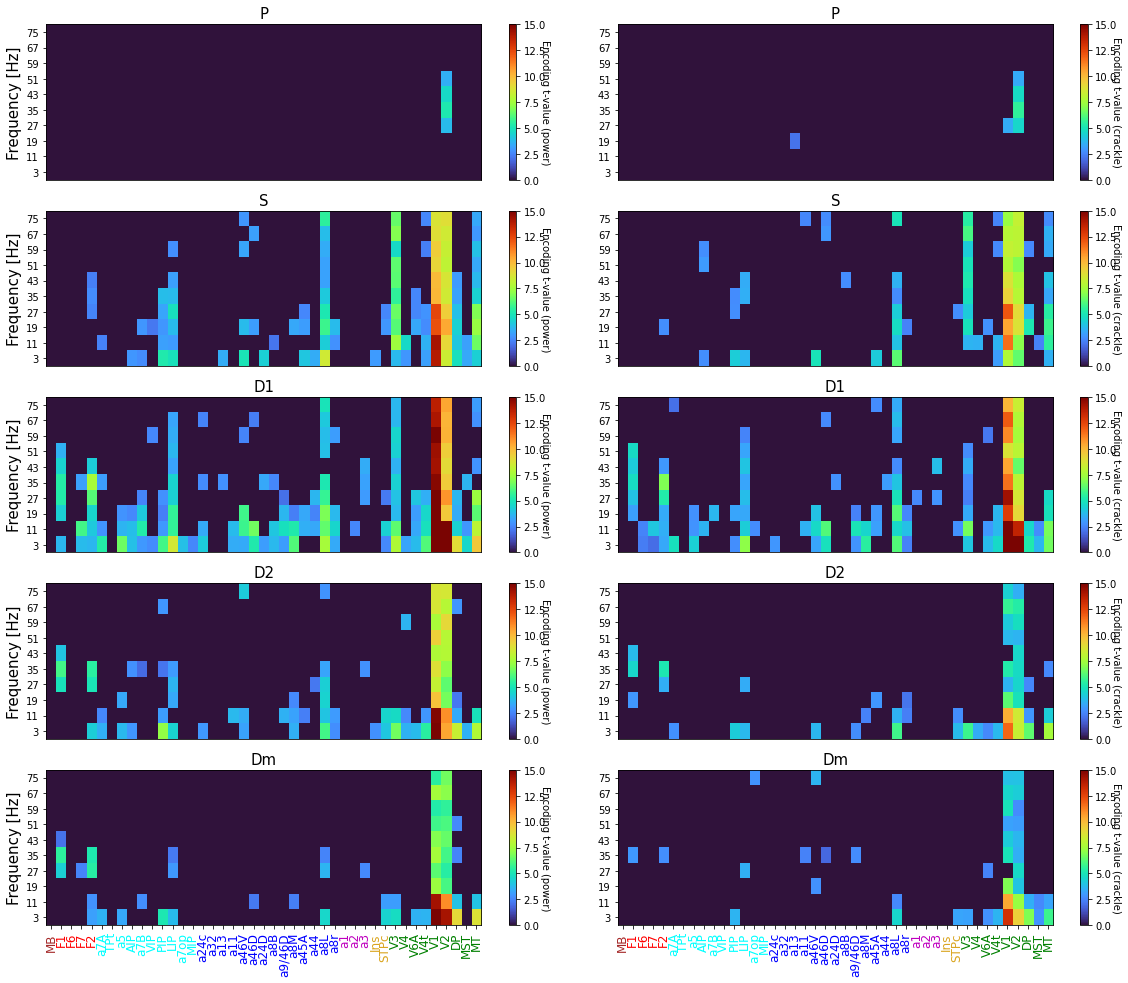

In [15]:
plt.figure(figsize=(20, 20))
pos = 1
for i in range(0, 5):
    # Power
    plt.subplot(6, 2, pos)
    plt.imshow(
        t_pow.sel(times=i).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=15,
        cmap="turbo",
        origin="lower",
    )
    if i == 4:
        tks = plt.xticks(
            range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=12
        )
        [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    else:
        plt.xticks([])
    plt.yticks(range(10), p_pow.freqs.data.astype(int))
    plt.ylabel("Frequency [Hz]", fontsize=15)
    plt.title(f"{stage_labels[i]}", fontsize=15)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Encoding t-value (power)", rotation=270)
    pos = pos + 1
    # Crackle
    plt.subplot(6, 2, pos)
    plt.imshow(
        t_crk.sel(times=i).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=15,
        cmap="turbo",
        origin="lower",
    )
    if i == 4:
        tks = plt.xticks(
            range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=12
        )
        [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    else:
        plt.xticks([])
    plt.yticks(range(10), p_pow.freqs.data.astype(int))
    plt.title(f"{stage_labels[i]}", fontsize=15)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Encoding t-value (crackle)", rotation=270)
    pos = pos + 1
plt.subplots_adjust(wspace=0.05)
plt.savefig("figures/n2/power_encoding.pdf", bbox_inches="tight")

In [16]:
import argparse
import os

import xarray as xr
from frites.dataset import DatasetEphy
from frites.estimator import GCMIEstimator
from frites.workflow import WfMi
from tqdm import tqdm

from config import get_dates, return_delay_split
from GDa.util import average_stages

In [17]:
def mi_visual_subsample(roi="V1", nboots=100, slvr_only=True):
    tt = 1
    br = 1
    at = "cue"
    avg = True

    sxx = []
    stim = []
    for s_id in tqdm(sessions):
        _FILE_NAME = f"power_tt_{tt}_br_{br}_at_{at}.nc"
        path_pow = os.path.join(_ROOT, f"Results/{monkey}/{s_id}/session01", _FILE_NAME)
        power = xr.load_dataarray(path_pow)
        rois = power.roi.data
        attrs = power.attrs
        sel_idx = rois==roi
        # Remove SLVR channels if slvr_only=False
        info = session_info(
            raw_path=os.path.join(_ROOT, "GrayLab"),
            monkey=monkey,
            date=s_id,
            session=1,
        )
        slvr_idx = info.recording_info["slvr"].astype(bool)
        if not bool(slvr_only):
            sel_idx = np.logical_and(np.logical_not(slvr_idx), sel_idx)
        else:
            sel_idx = np.logical_and(slvr_idx, sel_idx)
            
        power = power.isel(roi=sel_idx)

        # Averages power for each period (baseline, cue, delay, match) if needed
        # out = average_stages(power, avg, early_cue=early_cue,
        # early_delay=early_delay)
        # Average epochs
        out = []
        if avg:
            for t0, t1 in stages:
                out += [power.sel(times=slice(t0, t1)).mean("times")]
            out = xr.concat(out, "times")
            out = out.transpose("trials", "roi", "freqs", "times")
        else:
            out = power
        out.attrs = attrs
        sxx += [out.isel(roi=[r]) for r in range(len(out["roi"]))]
        stim += [out.attrs["stim"].astype(int)] * len(out["roi"])

    mis = []
    pvals = []
    for boot in tqdm(range(nboots)):

        # Subsample indexes
        idx = np.random.choice(range(len(sxx)), size=20, replace=False)

        sxx_ = [sxx[i] for i in idx]
        stim_ = [stim[i] for i in idx]

        # Convert to DatasetEphy
        dt = DatasetEphy(sxx_, y=stim_, nb_min_suj=10, times="times", roi="roi")

        mi_type = "cd"
        inference = "rfx"
        kernel = None

        if avg:
            mcp = "fdr"
        else:
            mcp = "cluster"

        mi_type = "cd"

        estimator = GCMIEstimator(
            mi_type="cd",
            copnorm=True,
            biascorrect=True,
            demeaned=False,
            tensor=True,
            gpu=False,
            verbose=False,
        )
        wf = WfMi(mi_type, inference, verbose=False, kernel=kernel, estimator=estimator)

        kw = dict(n_jobs=30, n_perm=200)
        cluster_th = None

        mi, pvalues = wf.fit(dt, mcp=mcp, cluster_th=cluster_th, **kw)
        mis += [mi]
        pvals += [pvalues]

    alpha = 0.001
    df = xr.concat(pvals, "boot").squeeze()
    return confidence_interval((df < alpha).astype(int), axis=0).squeeze()

In [18]:
ci_v1 = mi_visual_subsample(roi="V1", nboots=100, slvr_only=False)

  0%|          | 0/100 [00:00<?, ?it/s]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  1%|          | 1/100 [00:04<07:51,  4.76s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  2%|▏         | 2/100 [00:06<05:11,  3.18s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  3%|▎         | 3/100 [00:08<04:21,  2.70s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  4%|▍         | 4/100 [00:10<03:49,  2.39s/it]Definition of an electrophysiological

In [19]:
ci_v1_noslvr = mi_visual_subsample(roi="V1", nboots=100, slvr_only=True)

  0%|          | 0/100 [00:00<?, ?it/s]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  1%|          | 1/100 [00:01<03:15,  1.97s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  2%|▏         | 2/100 [00:03<03:02,  1.87s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  3%|▎         | 3/100 [00:05<03:04,  1.90s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  4%|▍         | 4/100 [00:07<03:01,  1.89s/it]Definition of an electrophysiological

In [20]:
ci_v2 = mi_visual_subsample(roi="V2", nboots=100, slvr_only=False)

  0%|          | 0/100 [00:00<?, ?it/s]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  1%|          | 1/100 [00:02<03:21,  2.03s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  2%|▏         | 2/100 [00:03<03:06,  1.90s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  3%|▎         | 3/100 [00:05<03:08,  1.94s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  4%|▍         | 4/100 [00:07<03:04,  1.93s/it]Definition of an electrophysiological

In [21]:
ci_v2_noslvr = mi_visual_subsample(roi="V2", nboots=100, slvr_only=True)

  0%|          | 0/100 [00:00<?, ?it/s]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  1%|          | 1/100 [00:01<03:03,  1.85s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  2%|▏         | 2/100 [00:03<03:05,  1.89s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  3%|▎         | 3/100 [00:05<03:07,  1.94s/it]Definition of an electrophysiological dataset
    Dataset composed of 20 subjects / sessions
    At least 10 subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)
  4%|▍         | 4/100 [00:07<03:06,  1.94s/it]Definition of an electrophysiological

In [22]:
data_loader = loader(_ROOT=_ROOT)

kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False, monkey=monkey
)

power_task = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)

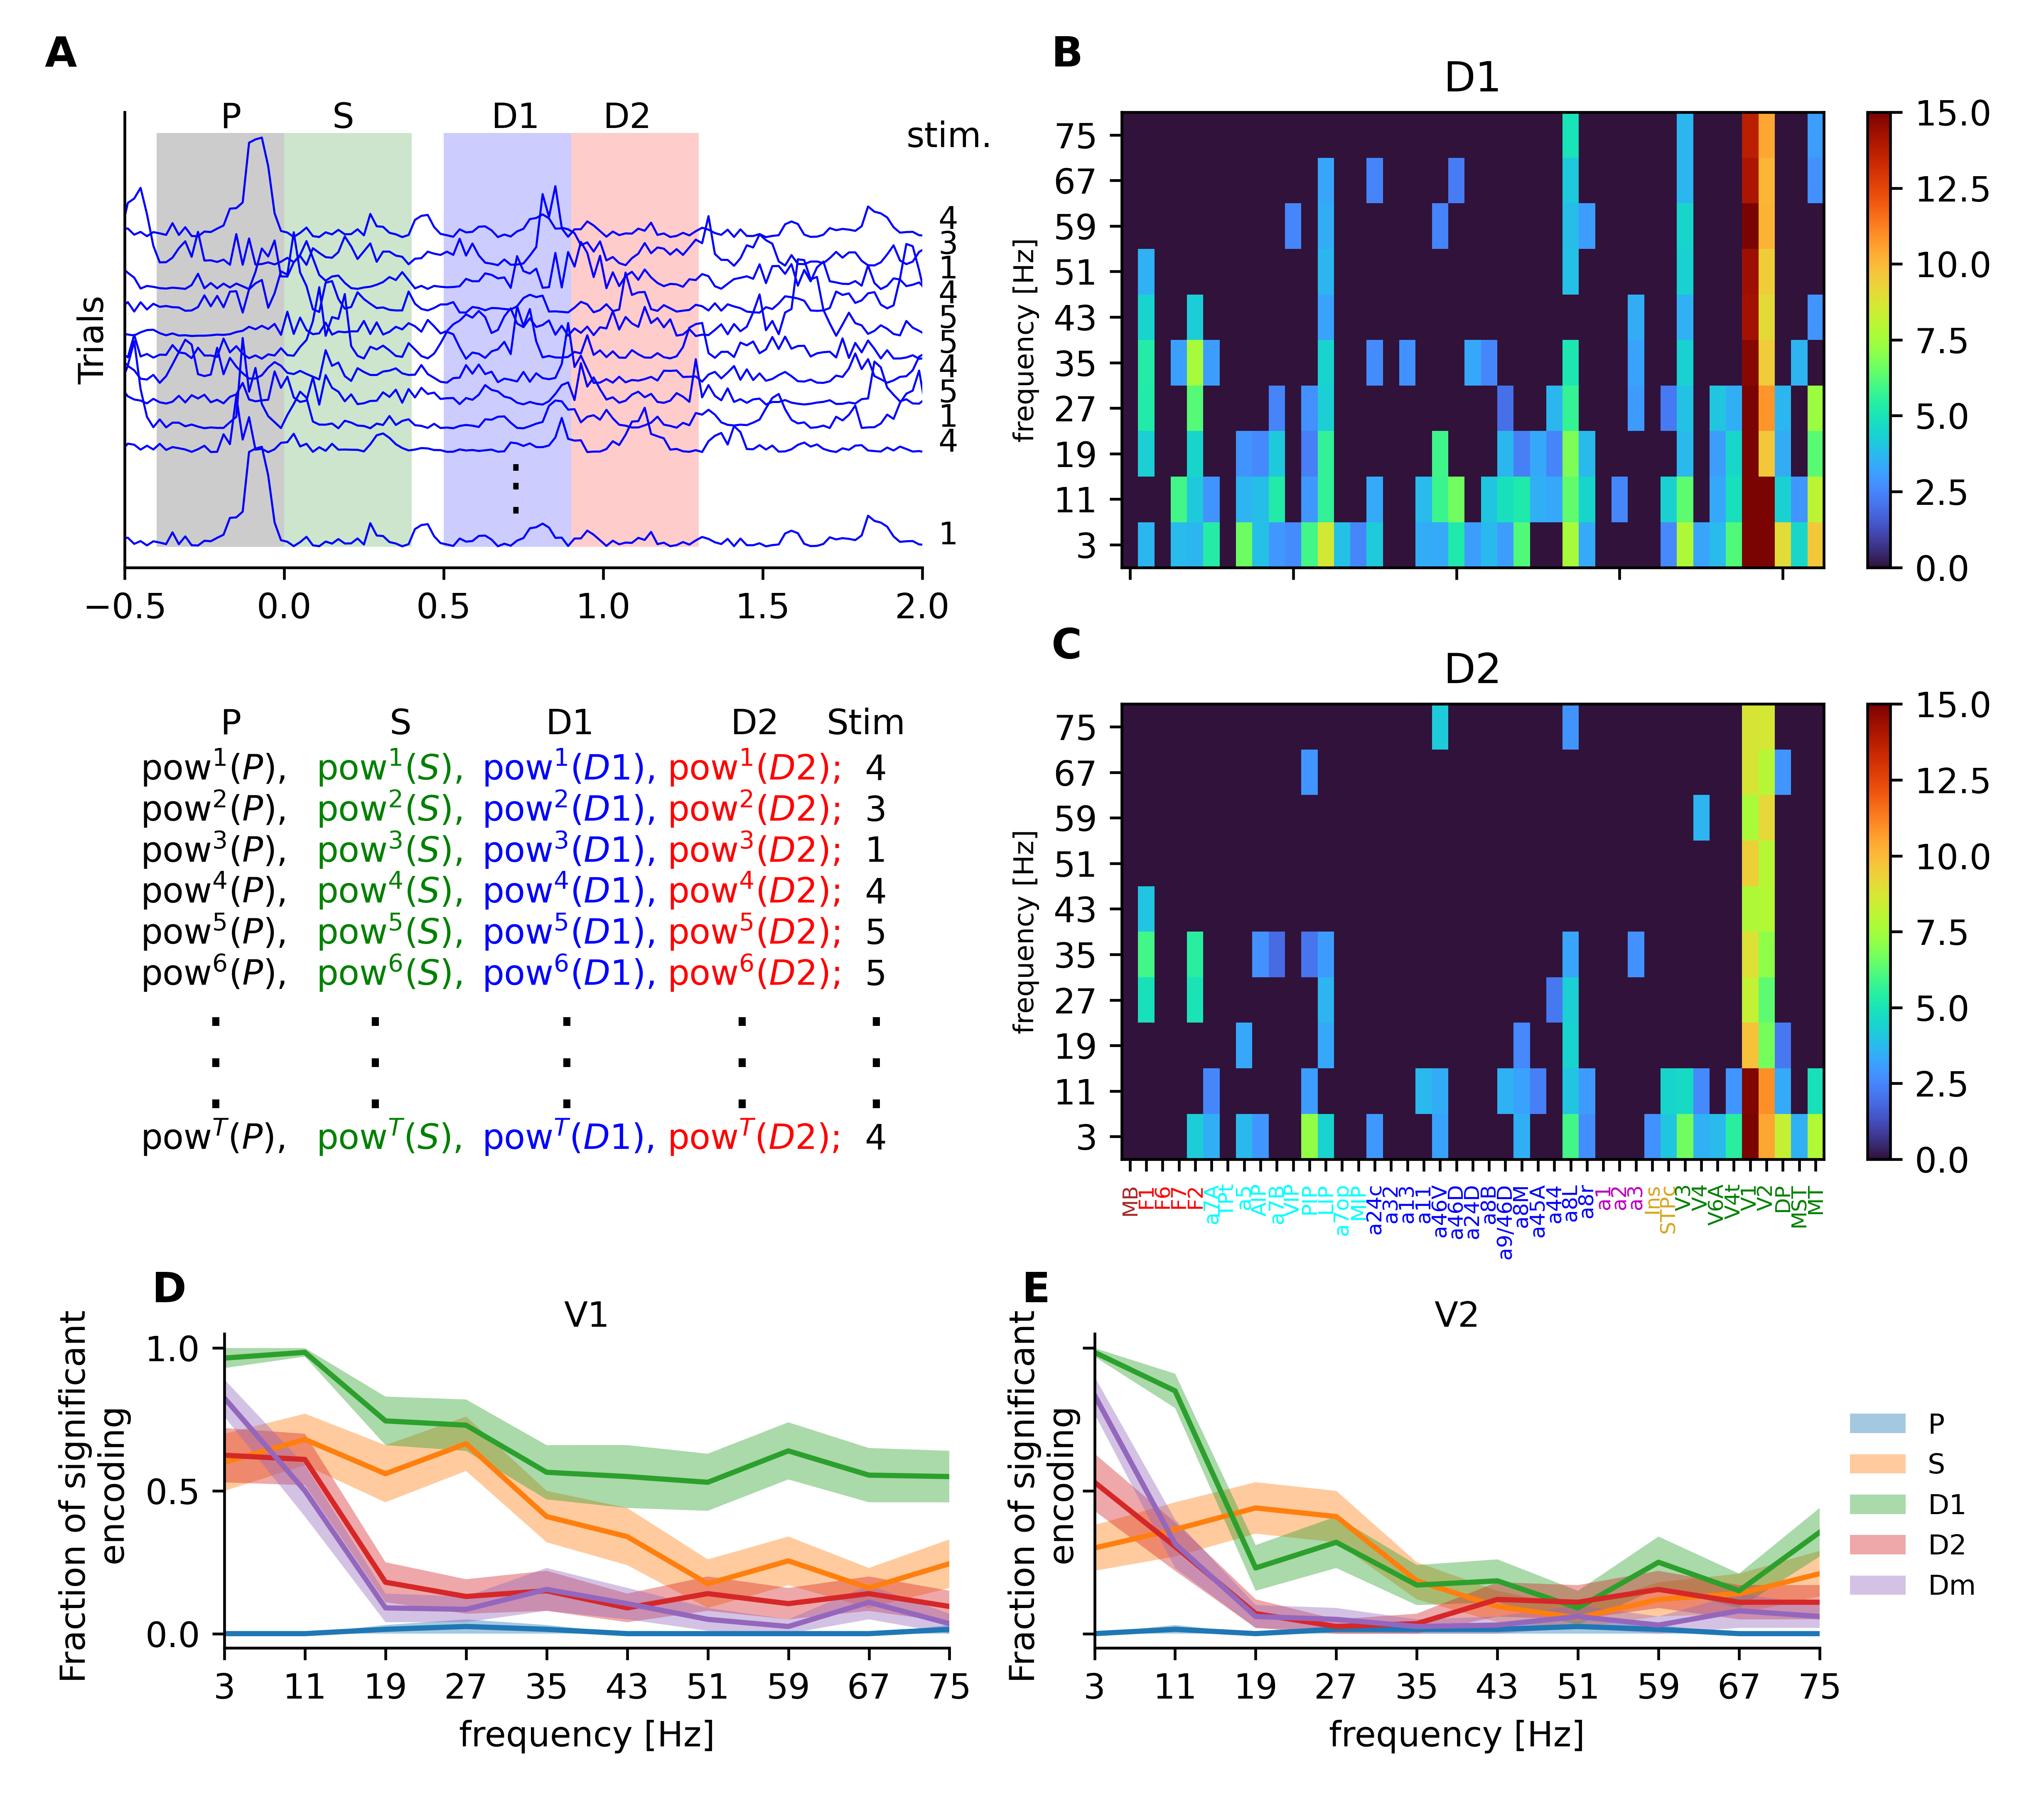

In [23]:
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(8, 7), dpi=600)

gs0 = fig.add_gridspec(
    nrows=2,
    ncols=1,
    left=0.05,
    right=0.45,
    hspace=0.3,
    bottom=0.35,
    top=0.95,
    height_ratios=(1, 1),
)

gs1 = fig.add_gridspec(
    nrows=2,
    ncols=1,
    left=0.55,
    right=0.99,
    hspace=0.3,
    bottom=0.35,
    top=0.95,
    height_ratios=(1, 1),
)

gs2 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.1,
    right=0.90,
    hspace=0.3,
    bottom=0.07,
    top=0.25,
)

axs0 = [plt.subplot(gs0[i]) for i in range(2)]

plt.sca(axs0[0])
v1ts = power_task.isel(roi=85).sel(freqs=27)
v1ts = (v1ts - v1ts.mean("times")) / v1ts.std("times")
times = v1ts.times.data

stims = np.random.randint(1, 6, 11)

for i in range(10):
    plt.plot(times, 3 * v1ts.isel(trials=i) + 5 * i, color="b", lw=0.6)
    plt.text(2.05, 5.2 * i - 2, f"{stims[i]}", fontsize=9)

plt.plot(times, 3 * v1ts.isel(trials=i) - 20, color="b", lw=0.6)
plt.text(2.05, -21.5, f"{stims[-1]}", fontsize=9)
plt.text(0.7, -15, ".", fontsize=15)
plt.text(0.7, -10, ".", fontsize=15)
plt.text(0.7, -6, ".", fontsize=15)
plt.text(1.95, 62, "stim.")
plt.xlim(-0.5, 2)

rP = Rectangle(
    (-0.4, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="k", alpha=0.2
)
rS = Rectangle(
    (0, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="g", alpha=0.2
)
rD1 = Rectangle(
    (0.5, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="b", alpha=0.2
)
rD2 = Rectangle(
    (0.9, -22), 0.4, 87, linewidth=1, edgecolor="none", facecolor="r", alpha=0.2
)


axs0[0].add_patch(rP)
plt.text(-0.2, 66, "P")
axs0[0].add_patch(rS)
plt.text(0.15, 66, "S")
axs0[0].add_patch(rD1)
plt.text(0.65, 66, "D1")
axs0[0].add_patch(rD2)
plt.text(1.0, 66, "D2")


[axs0[0].spines[key].set_visible(False) for key in ["top", "right"]]
plt.yticks([])
plt.ylabel("Trials")

plt.sca(axs0[1])
plt.ylim(0, 90)
plt.xlim(-0.5, 2)


plt.text(-0.2, 84, "P")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(-0.25, xpos, ".", fontsize=20)
        continue
    plt.text(-0.45, xpos, f"pow$^{exp}(P)$,")

plt.text(0.33, 84, "S")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(0.25, xpos, ".", fontsize=20)
        continue
    plt.text(0.1, xpos, f"pow$^{exp}(S)$,", color="g")


plt.text(0.82, 84, "D1")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(0.85, xpos, ".", fontsize=20)
        continue
    plt.text(0.62, xpos, f"pow$^{exp}(D1)$,", color="b")

plt.text(1.4, 84, "D2")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if i > 0:
        exp = 10 - i
    else:
        exp = "T"
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(1.4, xpos, ".", fontsize=20)
        continue
    plt.text(1.2, xpos, f"pow$^{exp}(D2)$;", color="r")

plt.text(1.7, 84, "Stim")
for i, xpos in enumerate(np.linspace(2, 75, 10)):
    if 10 - i > 6 and 10 - i <= 9:
        plt.text(1.82, xpos, ".", fontsize=20)
        continue
    plt.text(1.82, xpos, f"{stims[i]}")
plt.axis("off")

axs1 = [plt.subplot(gs1[i]) for i in range(2)]

for i in range(2):
    plt.sca(axs1[i])
    plt.imshow(
        t_pow.sel(times=i + 2).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=15,
        cmap="turbo",
        origin="lower",
    )
    if i == 1:
        tks = plt.xticks(
            range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=6
        )
        [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.yticks(range(10), t_pow.freqs.data.astype(int))
    plt.ylabel("frequency [Hz]", fontsize=8)
    cbar = plt.colorbar()
    plt.title(f"{stage_labels[i + 2]}")
plt.setp(axs1[0].get_xticklabels(), visible=False)


axs2 = [plt.subplot(gs2[i]) for i in range(2)]

ci = [ci_v1, ci_v2]
for pos in range(2):
    plt.sca(axs2[pos])
    for i in range(5):
        ci[pos].median("bound").isel(times=i).plot()
        plt.fill_between(
            ci[pos].freqs,
            ci[pos].sel(bound="low").isel(times=i),
            ci[pos].sel(bound="high").isel(times=i),
            alpha=0.4,
            label=f"{stage_labels[i]}",
        )
    if pos == 0:
        plt.title("V1", fontsize=10, pad=-1)
    else:
        plt.title("V2", fontsize=10, pad=-1)
        axs2[pos].legend(
            loc="right", bbox_to_anchor=(1.25, 0.45), ncol=1, fontsize=8, frameon=False
        )
        plt.ylabel("")
    plt.xlim(3, 75)
    plt.xticks(ci[pos].freqs.data.astype(int))
    plt.xlabel("frequency [Hz]")
    plt.ylabel("Fraction of significant \n encoding")
    [axs2[pos].spines[key].set_visible(False) for key in ["top", "right"]]
plt.xticks()
plt.setp(axs2[1].get_yticklabels(), visible=False)


plot.add_panel_letters(
    fig,
    axes=[axs0[0], axs1[0], axs1[1], axs2[0], axs2[1]],
    fontsize=12,
    xpos=[-0.1, -0.1, -0.1, -0.1, -0.1],
    ypos=[1.1, 1.1, 1.1, 1.1, 1.1],
)

bg = plot.Background(visible=False)

plt.savefig("figures/n3/figure7.pdf")

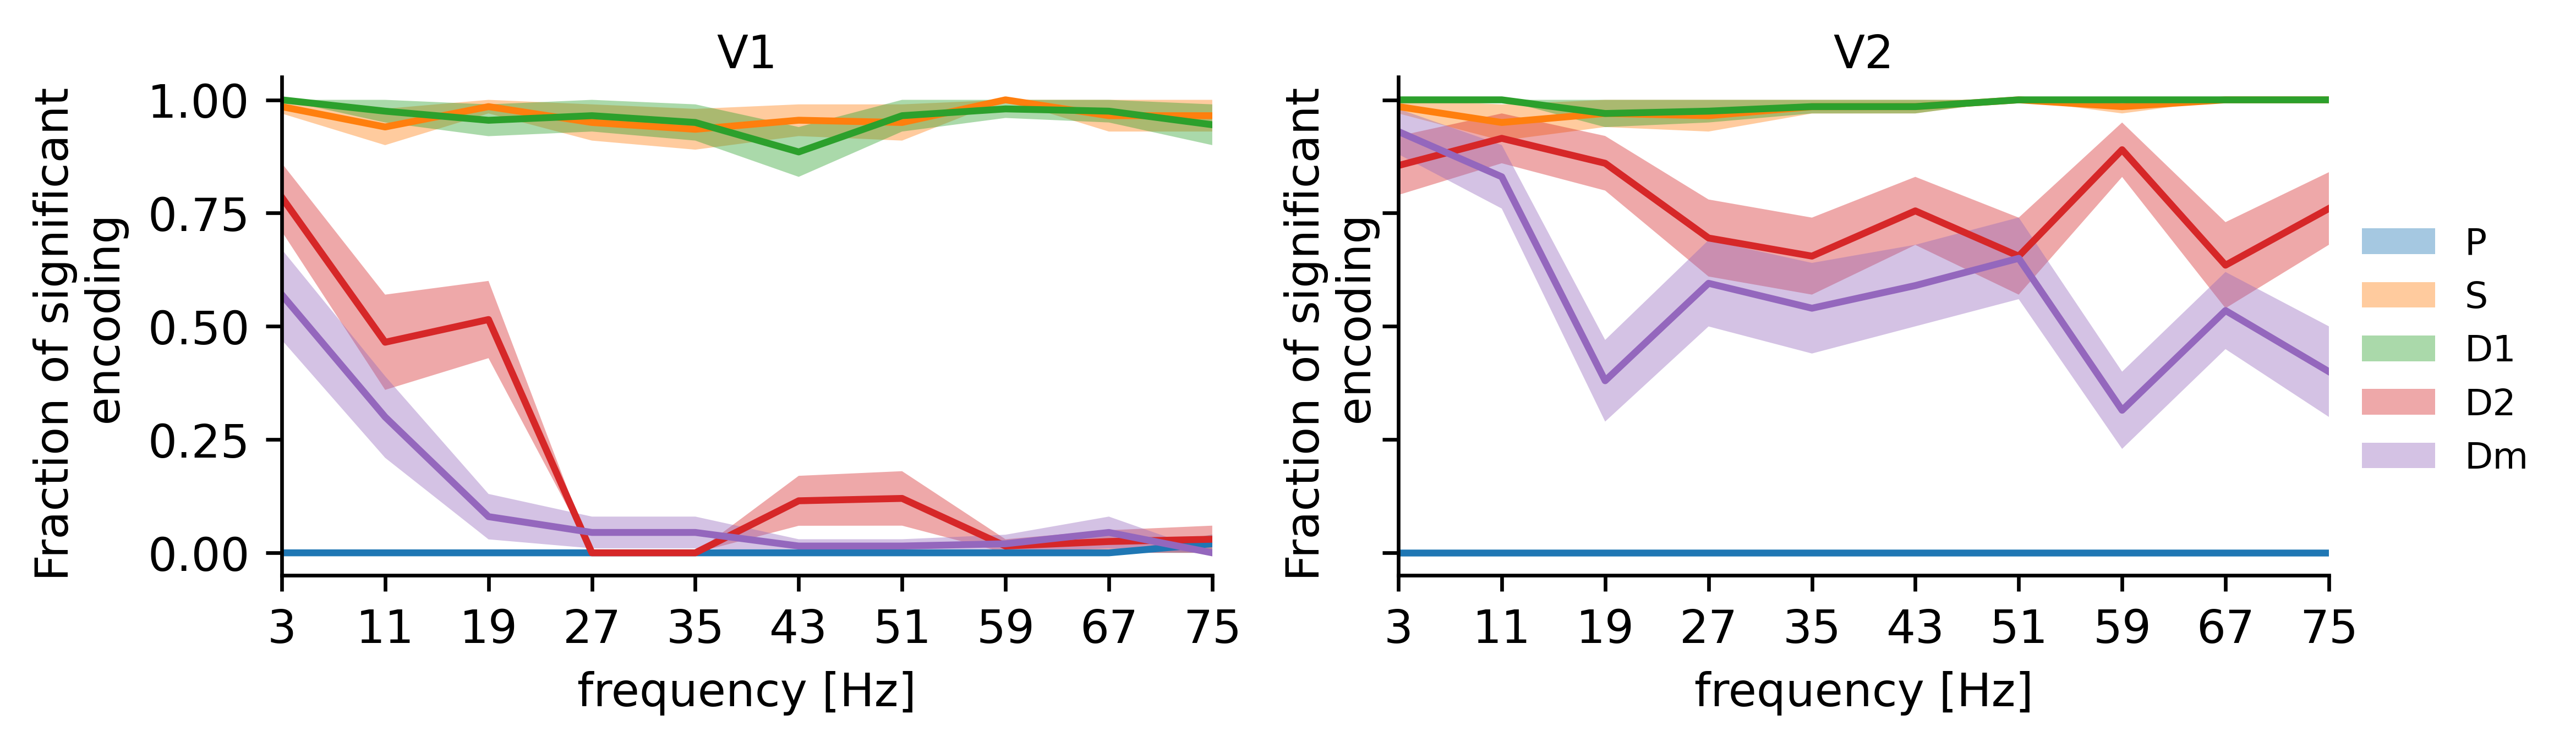

In [24]:
plt.figure(figsize=(8, 2), dpi=600)
ci = [ci_v1_noslvr, ci_v2_noslvr]
for pos in range(2):
    ax = plt.subplot(1, 2, pos + 1)
    for i in range(5):
        ci[pos].median("bound").isel(times=i).plot()
        plt.fill_between(
            ci[pos].freqs,
            ci[pos].sel(bound="low").isel(times=i),
            ci[pos].sel(bound="high").isel(times=i),
            alpha=0.4,
            label=f"{stage_labels[i]}",
        )
    if pos == 0:
        plt.title("V1", fontsize=10, pad=-1)
    else:
        plt.title("V2", fontsize=10, pad=-1)
        ax.legend(
            loc="right", bbox_to_anchor=(1.25, 0.45), ncol=1, fontsize=8, frameon=False
        )
        plt.ylabel("")
    plt.xlim(3, 75)
    plt.xticks(ci[pos].freqs.data.astype(int))
    plt.xlabel("frequency [Hz]")
    plt.ylabel("Fraction of significant \n encoding")
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xticks()
plt.setp(ax.get_yticklabels(), visible=False);

plt.savefig("figures/n3/figure7_slvr.png")

In [25]:
overlap = np.logical_and((p_pow <= 0.001), (p_crk <= 0.001))

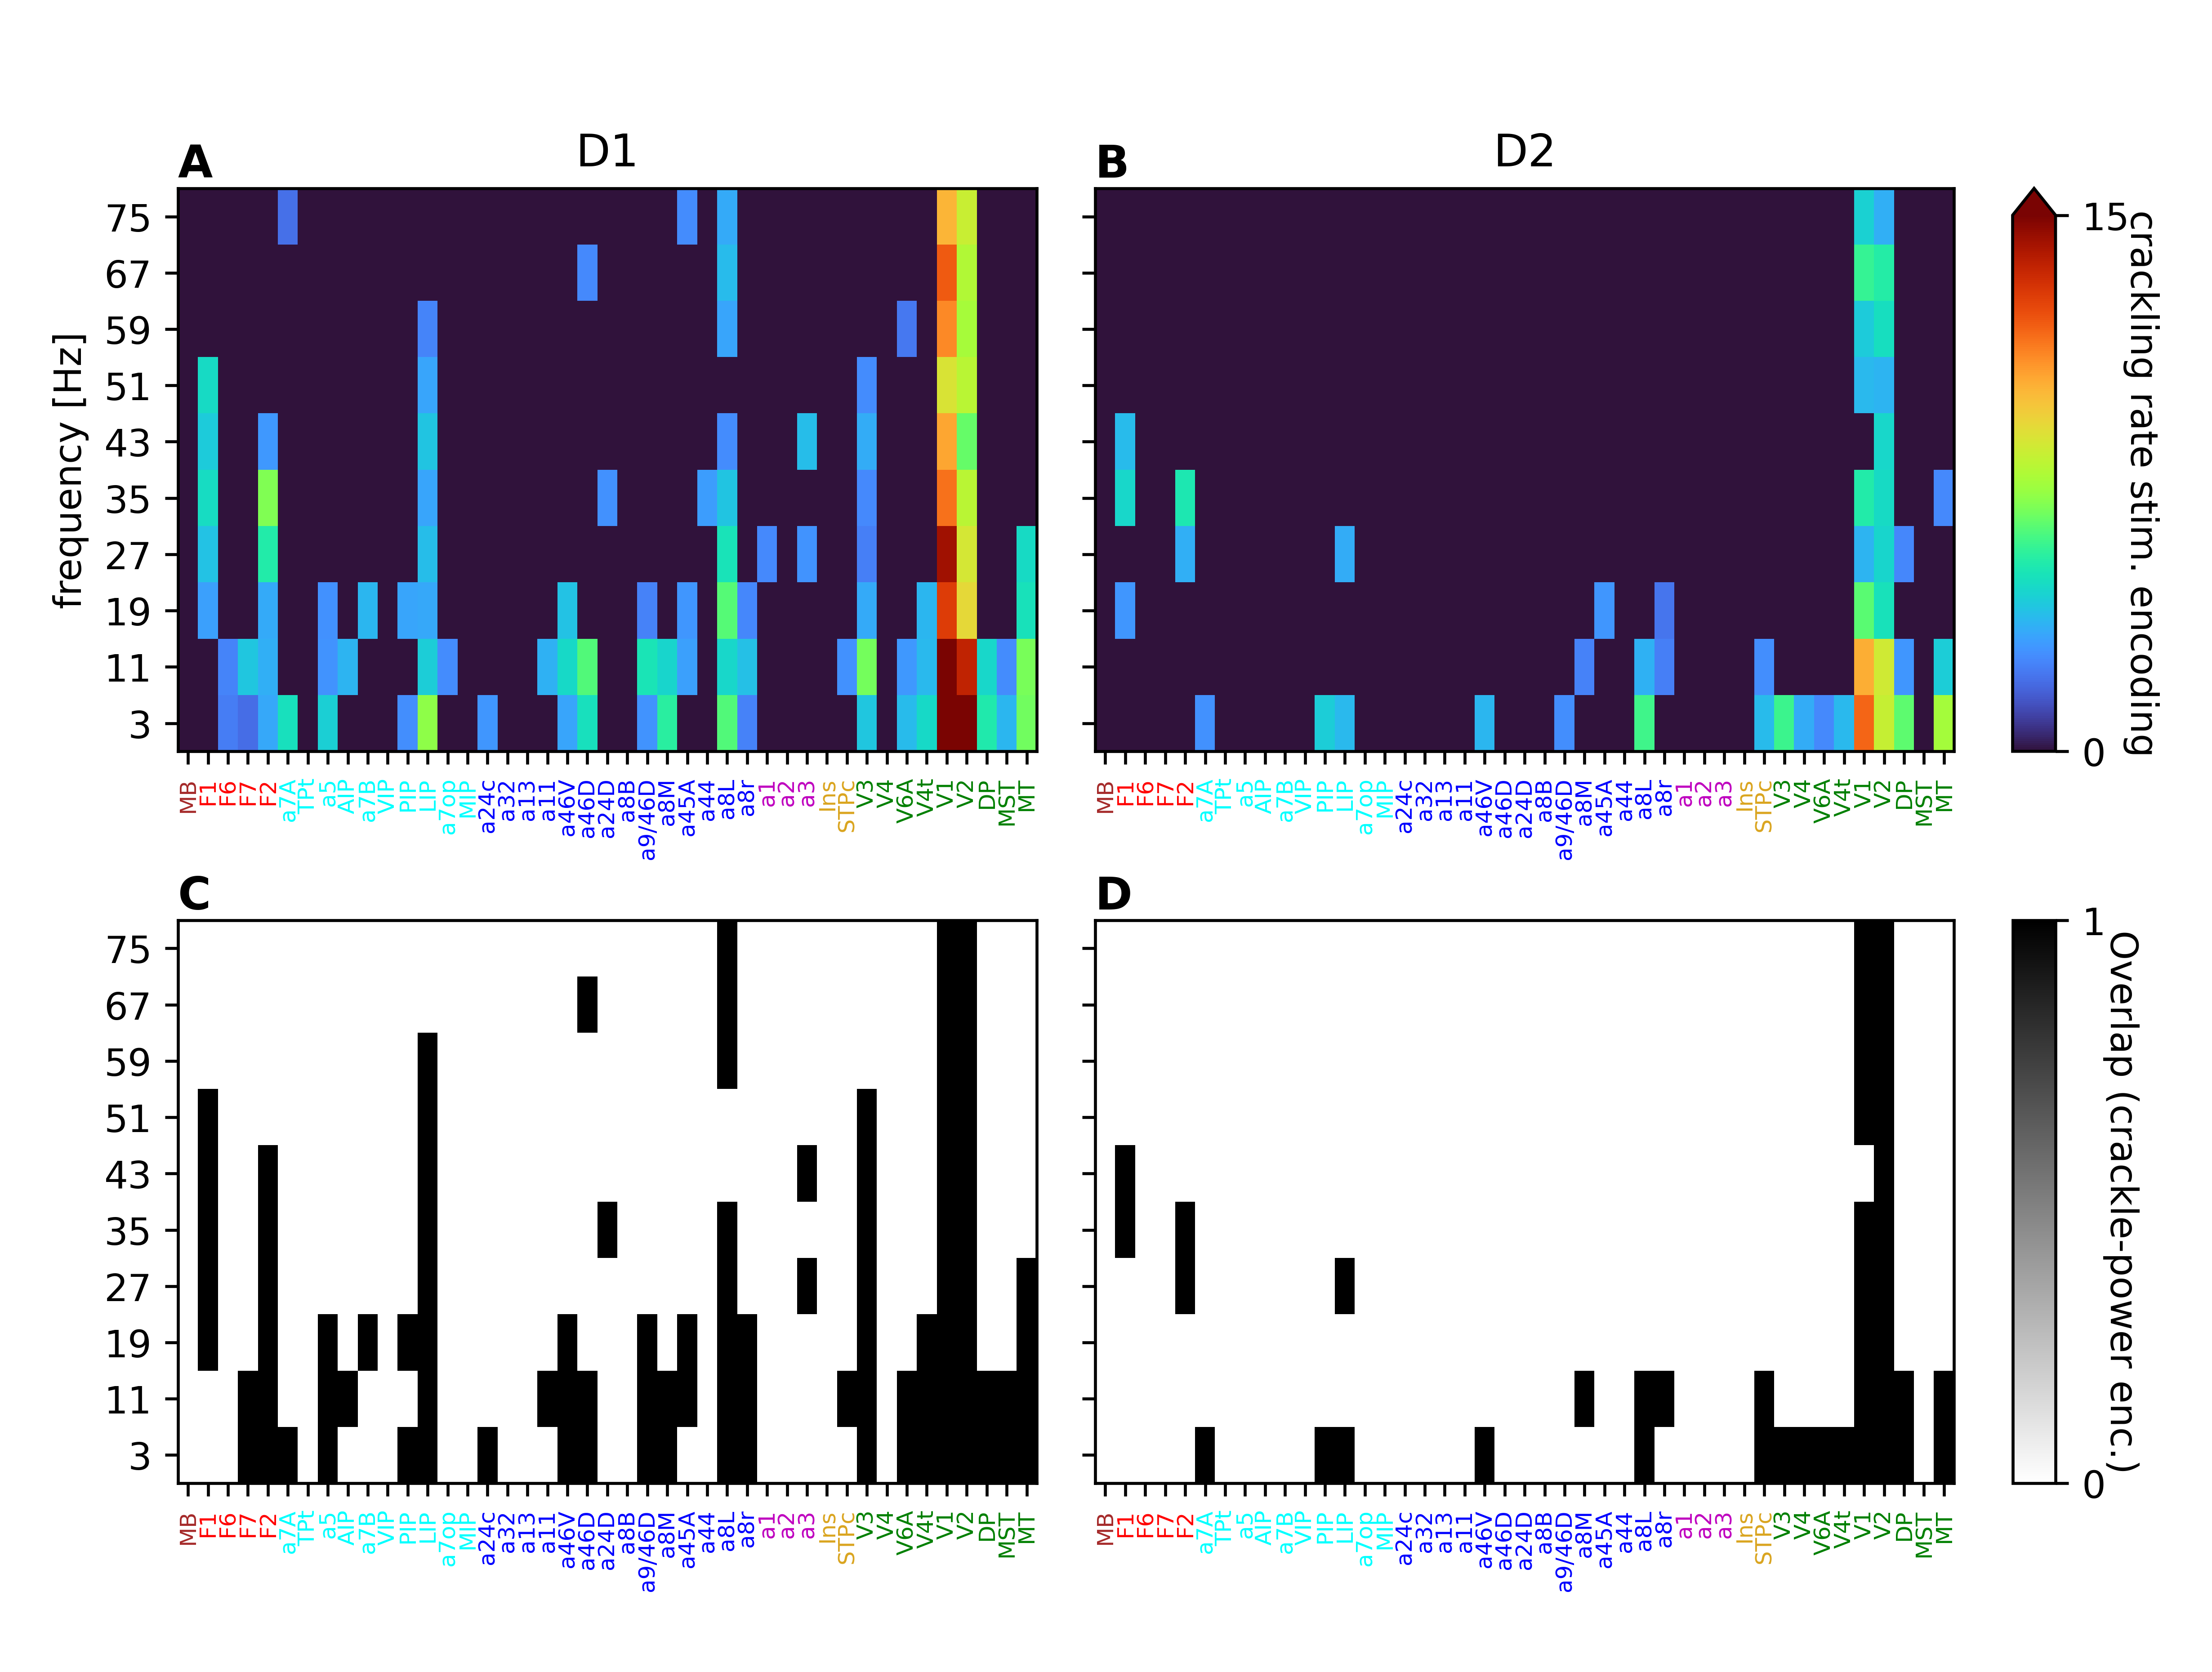

In [26]:
import matplotlib

fig = plt.figure(figsize=(8, 6), dpi=600)

gs0 = fig.add_gridspec(
    nrows=2,
    ncols=3,
    left=0.07,
    right=0.94,
    bottom=0.1,
    top=0.90,
    wspace=0.1,
    hspace=.3,
    width_ratios=(1, 1, 0.05),
)

axs0 = [plt.subplot(gs0[i]) for i in range(6)]

for i in range(2):
    plt.sca(axs0[i])
    plt.imshow(
        t_crk.sel(times=i + 2).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=15,
        cmap="turbo",
        origin="lower",
    )
    if i == 0:
        plt.ylabel("frequency [Hz]", fontsize=10)
    tks = plt.xticks(
        range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=6
    )
    [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.yticks(range(10), t_pow.freqs.data.astype(int))
    plt.title(f"{stage_labels[i + 2]}")
plt.setp(axs0[1].get_yticklabels(), visible=False)

norm = matplotlib.colors.Normalize(vmin=0, vmax=15)
cmap = matplotlib.cm.get_cmap("turbo")



cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 15],
    cax=axs0[2],
    extend="max",
)

cbar.ax.set_ylabel("crackling rate stim. encoding", rotation=270, labelpad=8)

##################################################################################################

for i in range(3, 5):
    plt.sca(axs0[i])
    plt.imshow(
        overlap.sel(times=i - 1).data[:, idx],
        aspect="auto",
        vmin=0,
        vmax=1,
        cmap="binary",
        origin="lower",
    )
    if i == 0:
        plt.ylabel("frequency [Hz]", fontsize=10)
    tks = plt.xticks(
        range(t_pow.sizes["roi"]), p_pow.roi.data[idx], rotation=90, fontsize=6
    )
    [tks[1][i].set_color(reg_colors[r]) for i, r in enumerate(regions[idx])]
    plt.yticks(range(10), t_pow.freqs.data.astype(int))
plt.setp(axs0[4].get_yticklabels(), visible=False)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cmap = matplotlib.cm.get_cmap("binary")


cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 1],
    cax=axs0[5],
    extend=None,
)


cbar.ax.set_ylabel("Overlap (crackle-power enc.)", rotation=270, labelpad=9)

bg = plot.Background(visible=False)

plot.add_panel_letters(
    fig,
    axes=[axs0[0], axs0[1], axs0[3], axs0[4]],
    fontsize=12,
    xpos=[0, 0, 0, 0],
    ypos=[1.02, 1.02, 1.02, 1.02],
)

plt.savefig("figures/n3/figure8.pdf")

In [96]:
def compute_for_session(session):

    kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

    power_task = data_loader.load_power(
        **kw_loader, trial_type=1, behavioral_response=1, session=session
    )

    power_task = node_xr_remove_sca(power_task)

    power_task_mean = []

    for t0, t1 in stages:
        power_task_mean += [
            power_task.sel(times=slice(t0, t1)).mean(("times", "trials"))
        ]

    power_task_mean = xr.concat(power_task_mean, "times")
    
    node_ent = data_loader.load_co_crakcle(session=session, strength=True)
    
    return power_task_mean, node_ent

In [97]:
power = []
node_ent = []
for session in tqdm(sessions):
    out_1, out_2 = compute_for_session(session) 
    power += [out_1]
    node_ent += [out_2]

100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


In [99]:
power = data_loader.apply_min_rois(power, 1).sel(roi=t_pow.roi)
node_ent = data_loader.apply_min_rois(node_ent, 1).sel(roi=t_pow.roi)

In [79]:
x = power.sel(freqs=35, times=3)
y = t_pow.sel(freqs=35, times=3)

<AxesSubplot:xlabel='power', ylabel='tvalues'>

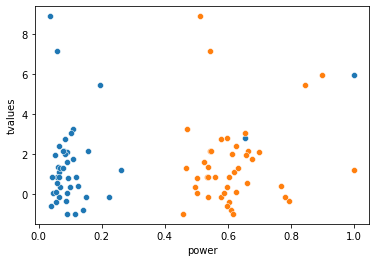

In [82]:
x = power.sel(freqs=35, times=3) / power.sel(freqs=35, times=3).max()
y = t_pow.sel(freqs=35, times=3)
sns.scatterplot(x=x, y=y)
x = node_ent.sel(freqs=35, times=3) / node_ent.sel(freqs=35, times=3).max()
y = t_pow.sel(freqs=35, times=3)
sns.scatterplot(x=x, y=y)

<xarray.DataArray (roi: 105, freqs: 10, times: 5)>
array([[[2.26245704, 3.00223368, 2.85154639, 2.5362543 , 2.00266323],
        [2.06701031, 2.89948454, 2.7225945 , 2.45369416, 2.16314433],
        [1.66469072, 2.00309278, 1.61005155, 1.43539519, 1.30455326],
        ...,
        [1.26554983, 1.03419244, 1.00068729, 1.0040378 , 1.04089347],
        [1.25498282, 1.19286942, 0.96262887, 1.05189003, 0.96400344],
        [1.04733677, 1.14286942, 0.98634021, 1.03943299, 0.96176976]],

       [[2.40085911, 2.63462199, 2.53694158, 2.56941581, 2.01752577],
        [2.4104811 , 2.87852234, 2.65532646, 2.31640893, 2.12689003],
        [1.76752577, 1.87448454, 1.47182131, 1.28573883, 1.16572165],
        ...,
        [1.13341924, 1.1992268 , 1.06752577, 1.13754296, 1.18840206],
        [1.3274055 , 1.20257732, 1.01056701, 1.10910653, 1.08187285],
        [1.24226804, 1.09888316, 1.00051546, 1.14295533, 1.03505155]],

       [[2.40798969, 2.30756014, 2.25996564, 2.29269759, 1.78015464],
        [2.51494845, 2.6782646 , 2.10713058, 2.14974227, 1.87242268],
        [1.82955326, 2.08943299, 1.28238832, 1.15764605, 1.07766323],
        ...,
...
        ...,
        [0.94166667, 0.75635739, 0.93934708, 1.39879725, 1.19054983],
        [0.99243986, 0.86709622, 0.9483677 , 1.42620275, 1.24364261],
        [0.87731959, 0.76993127, 0.93075601, 1.41426117, 1.24364261]],

       [[2.95257732, 2.55103093, 2.01400344, 2.57371134, 2.20764605],
        [2.24699313, 2.0152921 , 1.62225086, 2.12860825, 1.84235395],
        [1.23247423, 1.35369416, 1.04063574, 1.28565292, 1.30214777],
        ...,
        [1.00738832, 0.93161512, 0.83556701, 1.00025773, 0.95300687],
        [1.17164948, 0.98522337, 0.85292096, 1.06864261, 1.02268041],
        [1.08187285, 0.93685567, 0.94467354, 1.05876289, 1.02886598]],

       [[2.55962199, 2.46881443, 2.08127148, 2.63556701, 2.14793814],
        [2.25661512, 2.28934708, 1.87293814, 2.12216495, 1.7814433 ],
        [1.21838488, 1.28015464, 1.00601375, 1.15987973, 1.39931271],
        ...,
        [0.98530928, 0.94742268, 0.94106529, 1.26194158, 1.21108247],
        [1.06864261, 1.04716495, 0.95876289, 1.19347079, 1.14286942],
        [0.99768041, 0.97680412, 0.97431271, 1.22285223, 1.18685567]]])
Coordinates:
  * roi       (roi) object 'a46D' 'a24c' 'F6' 'a46D' ... 'V1' 'V1' 'V1' 'V1'
    quantile  float64 0.9
  * freqs     (freqs) float64 3.0 11.0 19.0 27.0 35.0 43.0 51.0 59.0 67.0 75.0
Dimensions without coordinates: times

In [84]:
node_ent = data_loader.load_co_crakcle(session="141024", strength=False)

In [95]:
node_ent.sum("targets").sel(freqs=27, times=3)

<xarray.DataArray (sources: 105)>
array([1.19664948, 1.06151203, 1.18771478, 1.12465636, 1.18986254,
       1.09072165, 1.11649485, 1.09209622, 1.04304124, 1.10773196,
       1.05274914, 1.01795533, 0.97723368, 0.95945017, 0.99905498,
       1.19209622, 1.17912371, 0.95343643, 1.04458763, 1.01743986,
       1.24965636, 0.95738832, 0.96812715, 0.70824742, 0.87027491,
       0.74089347, 0.91649485, 1.05292096, 1.16683849, 0.93857388,
       1.23487973, 0.60180412, 0.58608247, 0.64132302, 1.27474227,
       1.19304124, 1.2637457 , 1.28676976, 1.19166667, 1.28599656,
       1.25438144, 1.5217354 , 1.46941581, 1.17731959, 1.32233677,
       1.38642612, 1.2830756 , 1.33264605, 1.41417526, 1.38616838,
       1.08101375, 1.23049828, 1.24467354, 1.36563574, 1.29776632,
       1.28977663, 1.2137457 , 0.94982818, 1.21735395, 1.09828179,
       1.33840206, 1.09243986, 1.08934708, 1.20249141, 1.09785223,
       1.31726804, 1.27835052, 1.33135739, 1.08298969, 0.85867698,
       1.24484536, 1.24209622, 1.1637457 , 1.24089347, 1.36434708,
       1.41082474, 1.44304124, 0.78273196, 1.3137457 , 1.5830756 ,
       1.42001718, 1.45618557, 0.90790378, 0.87242268, 1.25764605,
       1.31752577, 1.41262887, 1.43024055, 1.39896907, 1.40721649,
       1.24304124, 0.74587629, 1.42310997, 1.40249141, 1.30171821,
       1.35283505, 1.045189  , 1.39458763, 1.46228522, 1.42680412,
       1.28230241, 1.34089347, 1.39261168, 1.08814433, 1.25300687])
Coordinates:
  * sources   (sources) object 'a46D' 'a24c' 'F6' 'a46D' ... 'V1' 'V1' 'V1' 'V1'
    quantile  float64 0.9
    freqs     float64 27.0

In [94]:
node_ent.sources.data[79]

'V2'

In [103]:
node_ent.sel(freqs=27, times=3).argmax()

<xarray.DataArray ()>
array(22)
Coordinates:
    quantile  float64 0.9
    freqs     float64 27.0

In [117]:
idx = np.argsort(node_ent.sel(freqs=27, times=3)).data

In [118]:
node_ent.roi.data[idx]

array(['a8L', 'a24D', 'F2', 'F7', 'a3', 'a45A', 'a46V', 'a32', 'V1',
       'a13', 'a24c', 'a11', 'a9/46D', 'MST', 'MB', 'a46D', 'F1', 'a8B',
       'a8r', 'Ins', 'V3', 'STPc', 'MT', 'AIP', 'TPt', 'a7op', 'a7A',
       'V4t', 'PIP', 'a8M', 'V2', 'a44', 'F6', 'a7B', 'VIP', 'LIP', 'V4',
       'a2', 'a5', 'MIP', 'DP', 'a1', 'V6A'], dtype=object)

In [116]:
np.argsort?

Signature: np.argsort(a, axis=-1, kind=None, order=None)
Docstring:
Returns the indices that would sort an array.

Perform an indirect sort along the given axis using the algorithm specified
by the `kind` keyword. It returns an array of indices of the same shape as
`a` that index data along the given axis in sorted order.

Parameters
----------
a : array_like
    Array to sort.
axis : int or None, optional
    Axis along which to sort.  The default is -1 (the last axis). If None,
    the flattened array is used.
kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
    Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
    and 'mergesort' use timsort under the covers and, in general, the
    actual implementation will vary with data type. The 'mergesort' option
    is retained for backwards compatibility.

    .. versionchanged:: 1.15.0.
       The 'stable' option was added.
order : str or list of str, optional
    When `a` is an array with fields define

In [119]:
node_ent = data_loader.load_co_crakcle(session="141024", strength=False)

In [120]:
node_ent

<xarray.DataArray (sources: 105, targets: 105, freqs: 10, times: 5)>
array([[[[0.10515464, 0.16400344, 0.16262887, 0.13926117, 0.12809278],
         [0.10996564, 0.15609966, 0.15781787, 0.14544674, 0.13367698],
         [0.11975945, 0.13616838, 0.13333333, 0.12611684, 0.11494845],
         ...,
         [0.10472509, 0.09261168, 0.09501718, 0.0911512 , 0.09750859],
         [0.10120275, 0.09982818, 0.08917526, 0.09536082, 0.09063574],
         [0.08986254, 0.10111684, 0.09020619, 0.09235395, 0.08883162]],

        [[0.03376289, 0.05489691, 0.06280069, 0.05558419, 0.04398625],
         [0.03608247, 0.05773196, 0.06099656, 0.05      , 0.04441581],
         [0.02216495, 0.0233677 , 0.02431271, 0.01958763, 0.01632302],
         ...,
         [0.01151203, 0.0097079 , 0.0104811 , 0.01065292, 0.01391753],
         [0.01305842, 0.01228522, 0.00816151, 0.01082474, 0.01082474],
         [0.00987973, 0.01082474, 0.00979381, 0.00790378, 0.00704467]],

        [[0.02585911, 0.0330756 , 0.03814433, 0.03350515, 0.02491409],
         [0.02585911, 0.03651203, 0.03436426, 0.03187285, 0.02852234],
         [0.01726804, 0.02216495, 0.01769759, 0.01701031, 0.01391753],
         ...,
...
         ...,
         [0.0097079 , 0.00661512, 0.01228522, 0.01829897, 0.01658076],
         [0.01013746, 0.00945017, 0.00953608, 0.01632302, 0.01400344],
         [0.01005155, 0.00824742, 0.01005155, 0.01752577, 0.01554983]],

        [[0.04802405, 0.05335052, 0.04974227, 0.06469072, 0.05738832],
         [0.03230241, 0.03170103, 0.03006873, 0.04467354, 0.03402062],
         [0.01563574, 0.01709622, 0.01658076, 0.02156357, 0.02405498],
         ...,
         [0.00850515, 0.01022337, 0.0097079 , 0.01262887, 0.00936426],
         [0.01056701, 0.00893471, 0.0080756 , 0.01159794, 0.01228522],
         [0.00953608, 0.00936426, 0.00747423, 0.01108247, 0.01254296]],

        [[0.12517182, 0.13376289, 0.11683849, 0.1467354 , 0.13487973],
         [0.11348797, 0.11924399, 0.10678694, 0.11718213, 0.09896907],
         [0.07517182, 0.07637457, 0.06795533, 0.08668385, 0.09802405],
         ...,
         [0.07568729, 0.07895189, 0.08118557, 0.11056701, 0.10798969],
         [0.08324742, 0.0871134 , 0.08410653, 0.10060137, 0.10223368],
         [0.08195876, 0.08393471, 0.08393471, 0.10429553, 0.10472509]]]])
Coordinates:
  * sources   (sources) object 'a46D' 'a24c' 'F6' 'a46D' ... 'V1' 'V1' 'V1' 'V1'
  * targets   (targets) object 'a46D' 'a24c' 'F6' 'a46D' ... 'V1' 'V1' 'V1' 'V1'
    quantile  float64 0.9
  * freqs     (freqs) float64 3.0 11.0 19.0 27.0 35.0 43.0 51.0 59.0 67.0 75.0
Dimensions without coordinates: times